In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
!pip install torch torchvision torchaudio pandas openpyxl scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


# YOLO + CNN

all data

Loading Models...

🚀 MEMULAI PIPELINE YOLO + CNN...

📂 Memproses Folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/gls
   ✅ Ditemukan 21 gambar.

📂 Memproses Folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nlb
   ✅ Ditemukan 26 gambar.

📂 Memproses Folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nls
   ✅ Ditemukan 26 gambar.

📊 MENGHITUNG mAP (YOLO VALIDATION)...
Menjalankan YOLO validator...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 228.6±48.0 MB/s, size: 2222.2 KB)
val: Scanning /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/labels/gls.cache... 73 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 73/73 73.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 40% ━━━━╸─────── 2/5 20.3s/it 22.3s<1:01
⚠️ Gagal menghitung mAP:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

✅ Semua hasil tersimpan di: /content/drive/MyDrive/EAS VISIKOM/output_YOLOCNN/Evaluasi_Total_baru


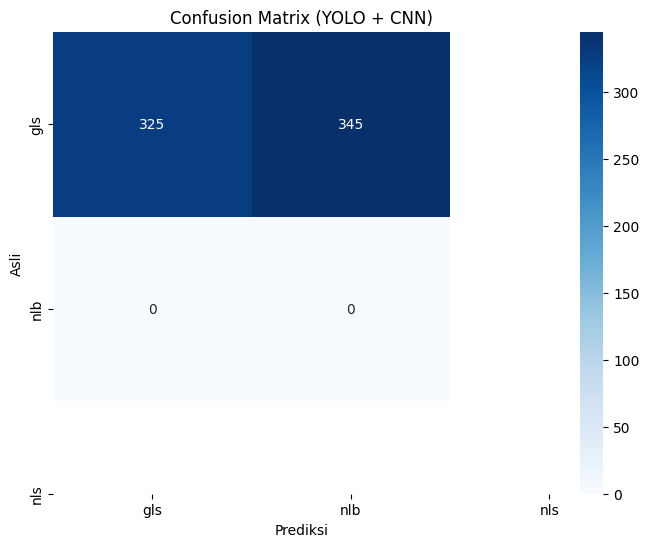

In [8]:
#0,5;0,25
import torch
import cv2
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf # Wajib untuk CNN Keras

# ================= 1. KONFIGURASI =================

# ⚠️ PENTING: Path arahkan ke folder INDUK (Parent)
INPUT_IMAGES_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images'
INPUT_LABELS_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test_single_class/labels'

# Output
OUTPUT_BASE_DIR = '/content/drive/MyDrive/EAS VISIKOM/output_YOLOCNN/Evaluasi_Total_baru'
OUTPUT_IMAGES_DIR = os.path.join(OUTPUT_BASE_DIR, 'Visualisasi_Citra')
os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)

# Model
YOLO_PATH = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/YOLO_best.pt'
CNN_PATH  = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/model_terbaikCNN.keras'

# Parameter
IOU_THRESHOLD = 0.5
CONF_THRESHOLD = 0.25
CNN_INPUT_SIZE = (128, 128) # Sesuaikan dengan input shape model CNN Anda
CLASS_NAMES = ['gls', 'nlb', 'nls'] # Urutan harus sesuai id kelas 0, 1, 2

# ================= 2. FUNGSI UTILITAS =================

def xywhn2xyxy(x, y, w, h, W, H):
    x1, y1 = int((x - w/2) * W), int((y - h/2) * H)
    x2, y2 = int((x + w/2) * W), int((y + h/2) * H)
    return [max(0, x1), max(0, y1), min(W, x2), min(H, y2)]

def calculate_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    return interArea / float((boxA[2]-boxA[0])*(boxA[3]-boxA[1]) + (boxB[2]-boxB[0])*(boxB[3]-boxB[1]) - interArea + 1e-6)

# Preprocessing Khusus CNN Keras (Rescale Only)
def preprocess_for_cnn(pil_image, target_size):
    img_resized = pil_image.resize(target_size)
    img_array = np.array(img_resized).astype(np.float32)
    img_array /= 255.0  # Rescale 1./255
    img_array = np.expand_dims(img_array, axis=0) # Batch dimension
    return img_array

# ================= 3. LOAD MODEL =================
print("Loading Models...")
# YOLO
yolo_model = YOLO(YOLO_PATH)

# CNN (Keras)
try:
    model_cnn = tf.keras.models.load_model(CNN_PATH)
except Exception as e:
    print(f"Error loading CNN: {e}")
    exit()

# ================= 4. MAIN LOOP (PIPELINE) =================
print("\n🚀 MEMULAI PIPELINE YOLO + CNN...")
y_true, y_pred, log_data = [], [], []

for class_name in CLASS_NAMES:
    # Gabungkan Path Induk + Nama Kelas
    current_img_dir = os.path.join(INPUT_IMAGES_ROOT, class_name)
    current_lbl_dir = os.path.join(INPUT_LABELS_ROOT, class_name)

    # Buat folder output per kelas
    save_class_dir = os.path.join(OUTPUT_IMAGES_DIR, class_name)
    os.makedirs(save_class_dir, exist_ok=True)

    print(f"\n📂 Memproses Folder: {current_img_dir}")

    if not os.path.isdir(current_img_dir):
        print(f"   ❌ Folder tidak ditemukan! Lewati...")
        continue

    # Cari gambar di folder kelas
    image_files = glob.glob(os.path.join(current_img_dir, "*.*"))
    valid_files = [f for f in image_files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(valid_files) == 0:
        print("   ⚠️ Folder kosong.")
        continue

    print(f"   ✅ Ditemukan {len(valid_files)} gambar.")

    for i, img_path in enumerate(valid_files):
        filename = os.path.basename(img_path)
        label_path = os.path.join(current_lbl_dir, os.path.splitext(filename)[0] + '.txt')

        # 1. Baca Gambar
        img_cv = cv2.imread(img_path)
        if img_cv is None: continue
        H, W, _ = img_cv.shape
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

        # 2. Baca Label GT
        gt_boxes, gt_classes = [], []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    d = line.strip().split()
                    if len(d) >= 5:
                        gt_classes.append(int(d[0]))
                        gt_boxes.append(xywhn2xyxy(float(d[1]), float(d[2]), float(d[3]), float(d[4]), W, H))

        # 3. Prediksi YOLO
        results = yolo_model(img_path, conf=CONF_THRESHOLD, verbose=False)
        pred_boxes = [box.xyxy[0].cpu().numpy().astype(int) for r in results for box in r.boxes]

        # 4. Matching & CNN Classification
        matched_gt_indices = set()
        img_viz = img_cv.copy()

        for idx_p, p_box in enumerate(pred_boxes):
            best_iou, best_gt_idx = 0, -1
            for idx_g, g_box in enumerate(gt_boxes):
                iou = calculate_iou(p_box, g_box)
                if iou > best_iou: best_iou, best_gt_idx = iou, idx_g

            # Crop & CNN Predict
            x1, y1, x2, y2 = map(int, p_box)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)

            crop = img_pil.crop((x1, y1, x2, y2))

            if crop.size[0] > 0 and crop.size[1] > 0:
                # Preprocess & Predict (Keras Style)
                input_data = preprocess_for_cnn(crop, CNN_INPUT_SIZE)
                tf_tensor = tf.convert_to_tensor(input_data)
                outputs = model_cnn.predict(tf_tensor, verbose=0)
                cnn_pred_cls = np.argmax(outputs, axis=1)[0]

                is_tp = (best_iou >= IOU_THRESHOLD)

                if is_tp:
                    matched_gt_indices.add(best_gt_idx)
                    gt_cls = gt_classes[best_gt_idx]
                    y_true.append(gt_cls)
                    y_pred.append(cnn_pred_cls)

                    status = "CORRECT" if gt_cls == cnn_pred_cls else "WRONG"
                    color = (0,255,0) if status=="CORRECT" else (0,0,255)
                    log_data.append([filename, CLASS_NAMES[gt_cls], CLASS_NAMES[cnn_pred_cls], best_iou, status])

                    cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img_viz, f"{status} ({CLASS_NAMES[cnn_pred_cls]})", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                else:
                    # FP
                    cv2.rectangle(img_viz, (x1, y1), (x2, y2), (0, 255, 255), 2)
                    cv2.putText(img_viz, "FP", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

        # 5. Cek Missed GT
        for idx_g, g_box in enumerate(gt_boxes):
            if idx_g not in matched_gt_indices:
                gt_cls = gt_classes[idx_g]
                y_true.append(gt_cls)
                y_pred.append(-1) # Missed

                cv2.rectangle(img_viz, (g_box[0], g_box[1]), (g_box[2], g_box[3]), (255,0,0), 2)
                cv2.putText(img_viz, f"Missed: {CLASS_NAMES[gt_cls]}", (g_box[0], g_box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
                log_data.append([filename, CLASS_NAMES[gt_cls], "Missed", 0, "Missed"])

        # SIMPAN GAMBAR
        save_path = os.path.join(save_class_dir, filename)
        cv2.imwrite(save_path, img_viz)

# ================= 5. METRIK DETEKSI (mAP) =================
print("\n" + "="*30)
print("📊 MENGHITUNG mAP (YOLO VALIDATION)...")
print("="*30)

map50 = 0
map5095 = 0

try:
    # 1. Buat file data.yaml sementara agar YOLO bisa validasi otomatis
    # Kita arahkan path 'val' ke folder parent images (YOLO recursive scan)
    ROOT_DATASET_DIR = os.path.dirname(INPUT_IMAGES_ROOT) # .../test

    # Isi file YAML
    yaml_content = f"""
path: {ROOT_DATASET_DIR}
train: images # Tidak dipakai saat val, tapi wajib ada
val: images   # Folder images (akan scan gls/nlb/nls)
names:
  0: {CLASS_NAMES[0]}
  1: {CLASS_NAMES[1]}
  2: {CLASS_NAMES[2]}
"""
    with open('temp_map_config.yaml', 'w') as f:
        f.write(yaml_content)

    print("Menjalankan YOLO validator...")
    # Jalankan validasi menggunakan model YOLO
    metrics_yolo = yolo_model.val(data='temp_map_config.yaml', split='val', verbose=False)

    map50 = metrics_yolo.box.map50
    map5095 = metrics_yolo.box.map

    print(f"✅ mAP@50    : {map50:.4f}")
    print(f"✅ mAP@50-95 : {map5095:.4f}")

except Exception as e:
    print(f"⚠️ Gagal menghitung mAP: {e}")
    print("   Pastikan folder images berisi subfolder gls/nlb/nls dan labels juga demikian.")


# ================= 6. METRIK PIPELINE & LAPORAN =================
print("\n" + "="*30)
if len(y_true) == 0:
    print("❌ ERROR: Data Evaluasi Kosong.")
else:
    print(f"✅ Evaluasi Pipeline Selesai. Total Data: {len(y_true)}")

    # Metrik Klasifikasi
    y_pred_clean = [p if p != -1 else (t + 1) % len(CLASS_NAMES) for p, t in zip(y_pred, y_true)]
    acc = accuracy_score(y_true, y_pred_clean)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred_clean, average='weighted', zero_division=0)

    print(f"   Akurasi Pipeline: {acc:.4f}")

    # Buat DataFrame Summary (Termasuk mAP)
    df_metrics = pd.DataFrame([
        ['Accuracy (Pipeline)', acc],
        ['Precision (Pipeline)', prec],
        ['Recall (Pipeline)', rec],
        ['F1-Score (Pipeline)', f1],
        ['mAP@50 (YOLO)', map50],
        ['mAP@50-95 (YOLO)', map5095]
    ], columns=['Metric', 'Value'])

    # Simpan Excel
    excel_path = os.path.join(OUTPUT_BASE_DIR, 'Laporan_Evaluasi_Lengkap.xlsx')
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        df_metrics.to_excel(writer, sheet_name='Summary', index=False)

        # Classification Report
        cls_rep = classification_report(y_true, y_pred_clean, target_names=CLASS_NAMES, labels=range(len(CLASS_NAMES)), output_dict=True)
        pd.DataFrame(cls_rep).transpose().to_excel(writer, sheet_name='Class_Report')

        # Detail Log
        df_log = pd.DataFrame(log_data, columns=['File', 'GT', 'Pred', 'IoU', 'Status'])
        df_log.to_excel(writer, sheet_name='Detail_Log', index=False)

    # Confusion Matrix
    try:
        cm = confusion_matrix(y_true, y_pred_clean)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix (YOLO + CNN)')
        plt.xlabel('Prediksi')
        plt.ylabel('Asli')
        plt.savefig(os.path.join(OUTPUT_BASE_DIR, 'confusion_matrix.png'))
    except: pass

    print(f"✅ Semua hasil tersimpan di: {OUTPUT_BASE_DIR}")

Loading Models...

🚀 MEMULAI PIPELINE YOLO + CNN...

📂 Memproses Folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/gls
   ✅ Ditemukan 21 gambar.

📂 Memproses Folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nlb
   ✅ Ditemukan 26 gambar.

📂 Memproses Folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nls
   ✅ Ditemukan 26 gambar.

📊 MENGHITUNG mAP (YOLO VALIDATION)...
Menjalankan YOLO validator...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 198.4±62.9 MB/s, size: 2287.8 KB)
val: Scanning /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/labels/gls.cache... 73 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 73/73 73.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 40% ━━━━╸─────── 2/5 20.6s/it 20.9s<1:02
⚠️ Gagal menghitung mAP:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Semua hasil tersimpan di: /content/drive/MyDrive/EAS VISIKOM/output_YOLOCNN/Evaluasi_Total2


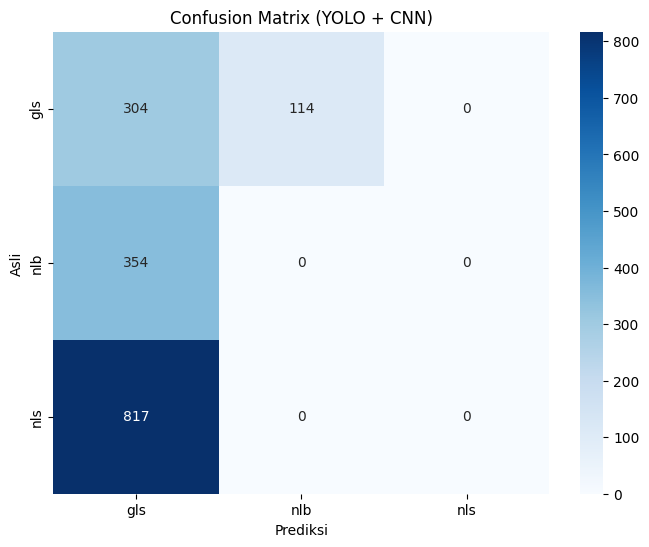

In [4]:
#0,25;0,01
import torch
import cv2
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf # Wajib untuk CNN Keras

# ================= 1. KONFIGURASI =================

# ⚠️ PENTING: Path arahkan ke folder INDUK (Parent)
INPUT_IMAGES_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images'
INPUT_LABELS_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/labels'

# Output
OUTPUT_BASE_DIR = '/content/drive/MyDrive/EAS VISIKOM/output_YOLOCNN/Evaluasi_Total2'
OUTPUT_IMAGES_DIR = os.path.join(OUTPUT_BASE_DIR, 'Visualisasi_Citra')
os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)

# Model
YOLO_PATH = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/YOLO_best.pt'
CNN_PATH  = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/model_terbaikCNN.keras'

# Parameter
IOU_THRESHOLD = 0.25
CONF_THRESHOLD = 0.01
CNN_INPUT_SIZE = (128, 128) # Sesuaikan dengan input shape model CNN Anda
CLASS_NAMES = ['gls', 'nlb', 'nls'] # Urutan harus sesuai id kelas 0, 1, 2

# ================= 2. FUNGSI UTILITAS =================

def xywhn2xyxy(x, y, w, h, W, H):
    x1, y1 = int((x - w/2) * W), int((y - h/2) * H)
    x2, y2 = int((x + w/2) * W), int((y + h/2) * H)
    return [max(0, x1), max(0, y1), min(W, x2), min(H, y2)]

def calculate_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    return interArea / float((boxA[2]-boxA[0])*(boxA[3]-boxA[1]) + (boxB[2]-boxB[0])*(boxB[3]-boxB[1]) - interArea + 1e-6)

# Preprocessing Khusus CNN Keras (Rescale Only)
def preprocess_for_cnn(pil_image, target_size):
    img_resized = pil_image.resize(target_size)
    img_array = np.array(img_resized).astype(np.float32)
    img_array /= 255.0  # Rescale 1./255
    img_array = np.expand_dims(img_array, axis=0) # Batch dimension
    return img_array

# ================= 3. LOAD MODEL =================
print("Loading Models...")
# YOLO
yolo_model = YOLO(YOLO_PATH)

# CNN (Keras)
try:
    model_cnn = tf.keras.models.load_model(CNN_PATH)
except Exception as e:
    print(f"Error loading CNN: {e}")
    exit()

# ================= 4. MAIN LOOP (PIPELINE) =================
print("\n🚀 MEMULAI PIPELINE YOLO + CNN...")
y_true, y_pred, log_data = [], [], []

for class_name in CLASS_NAMES:
    # Gabungkan Path Induk + Nama Kelas
    current_img_dir = os.path.join(INPUT_IMAGES_ROOT, class_name)
    current_lbl_dir = os.path.join(INPUT_LABELS_ROOT, class_name)

    # Buat folder output per kelas
    save_class_dir = os.path.join(OUTPUT_IMAGES_DIR, class_name)
    os.makedirs(save_class_dir, exist_ok=True)

    print(f"\n📂 Memproses Folder: {current_img_dir}")

    if not os.path.isdir(current_img_dir):
        print(f"   ❌ Folder tidak ditemukan! Lewati...")
        continue

    # Cari gambar di folder kelas
    image_files = glob.glob(os.path.join(current_img_dir, "*.*"))
    valid_files = [f for f in image_files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(valid_files) == 0:
        print("   ⚠️ Folder kosong.")
        continue

    print(f"   ✅ Ditemukan {len(valid_files)} gambar.")

    for i, img_path in enumerate(valid_files):
        filename = os.path.basename(img_path)
        label_path = os.path.join(current_lbl_dir, os.path.splitext(filename)[0] + '.txt')

        # 1. Baca Gambar
        img_cv = cv2.imread(img_path)
        if img_cv is None: continue
        H, W, _ = img_cv.shape
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

        # 2. Baca Label GT
        gt_boxes, gt_classes = [], []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    d = line.strip().split()
                    if len(d) >= 5:
                        gt_classes.append(int(d[0]))
                        gt_boxes.append(xywhn2xyxy(float(d[1]), float(d[2]), float(d[3]), float(d[4]), W, H))

        # 3. Prediksi YOLO
        results = yolo_model(img_path, conf=CONF_THRESHOLD, verbose=False)
        pred_boxes = [box.xyxy[0].cpu().numpy().astype(int) for r in results for box in r.boxes]

        # 4. Matching & CNN Classification
        matched_gt_indices = set()
        img_viz = img_cv.copy()

        for idx_p, p_box in enumerate(pred_boxes):
            best_iou, best_gt_idx = 0, -1
            for idx_g, g_box in enumerate(gt_boxes):
                iou = calculate_iou(p_box, g_box)
                if iou > best_iou: best_iou, best_gt_idx = iou, idx_g

            # Crop & CNN Predict
            x1, y1, x2, y2 = map(int, p_box)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)

            crop = img_pil.crop((x1, y1, x2, y2))

            if crop.size[0] > 0 and crop.size[1] > 0:
                # Preprocess & Predict (Keras Style)
                input_data = preprocess_for_cnn(crop, CNN_INPUT_SIZE)
                tf_tensor = tf.convert_to_tensor(input_data)
                outputs = model_cnn.predict(tf_tensor, verbose=0)
                cnn_pred_cls = np.argmax(outputs, axis=1)[0]

                is_tp = (best_iou >= IOU_THRESHOLD)

                if is_tp:
                    matched_gt_indices.add(best_gt_idx)
                    gt_cls = gt_classes[best_gt_idx]
                    y_true.append(gt_cls)
                    y_pred.append(cnn_pred_cls)

                    status = "CORRECT" if gt_cls == cnn_pred_cls else "WRONG"
                    color = (0,255,0) if status=="CORRECT" else (0,0,255)
                    log_data.append([filename, CLASS_NAMES[gt_cls], CLASS_NAMES[cnn_pred_cls], best_iou, status])

                    cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img_viz, f"{status} ({CLASS_NAMES[cnn_pred_cls]})", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                else:
                    # FP
                    cv2.rectangle(img_viz, (x1, y1), (x2, y2), (0, 255, 255), 2)
                    cv2.putText(img_viz, "FP", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

        # 5. Cek Missed GT
        for idx_g, g_box in enumerate(gt_boxes):
            if idx_g not in matched_gt_indices:
                gt_cls = gt_classes[idx_g]
                y_true.append(gt_cls)
                y_pred.append(-1) # Missed

                cv2.rectangle(img_viz, (g_box[0], g_box[1]), (g_box[2], g_box[3]), (255,0,0), 2)
                cv2.putText(img_viz, f"Missed: {CLASS_NAMES[gt_cls]}", (g_box[0], g_box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
                log_data.append([filename, CLASS_NAMES[gt_cls], "Missed", 0, "Missed"])

        # SIMPAN GAMBAR
        save_path = os.path.join(save_class_dir, filename)
        cv2.imwrite(save_path, img_viz)

# ================= 5. METRIK DETEKSI (mAP) =================
print("\n" + "="*30)
print("📊 MENGHITUNG mAP (YOLO VALIDATION)...")
print("="*30)

map50 = 0
map5095 = 0

try:
    # 1. Buat file data.yaml sementara agar YOLO bisa validasi otomatis
    # Kita arahkan path 'val' ke folder parent images (YOLO recursive scan)
    ROOT_DATASET_DIR = os.path.dirname(INPUT_IMAGES_ROOT) # .../test

    # Isi file YAML
    yaml_content = f"""
path: {ROOT_DATASET_DIR}
train: images # Tidak dipakai saat val, tapi wajib ada
val: images   # Folder images (akan scan gls/nlb/nls)
names:
  0: {CLASS_NAMES[0]}
  1: {CLASS_NAMES[1]}
  2: {CLASS_NAMES[2]}
"""
    with open('temp_map_config.yaml', 'w') as f:
        f.write(yaml_content)

    print("Menjalankan YOLO validator...")
    # Jalankan validasi menggunakan model YOLO
    metrics_yolo = yolo_model.val(data='temp_map_config.yaml', split='val', verbose=False)

    map50 = metrics_yolo.box.map50
    map5095 = metrics_yolo.box.map

    print(f"✅ mAP@50    : {map50:.4f}")
    print(f"✅ mAP@50-95 : {map5095:.4f}")

except Exception as e:
    print(f"⚠️ Gagal menghitung mAP: {e}")
    print("   Pastikan folder images berisi subfolder gls/nlb/nls dan labels juga demikian.")


# ================= 6. METRIK PIPELINE & LAPORAN =================
print("\n" + "="*30)
if len(y_true) == 0:
    print("❌ ERROR: Data Evaluasi Kosong.")
else:
    print(f"✅ Evaluasi Pipeline Selesai. Total Data: {len(y_true)}")

    # Metrik Klasifikasi
    y_pred_clean = [p if p != -1 else (t + 1) % len(CLASS_NAMES) for p, t in zip(y_pred, y_true)]
    acc = accuracy_score(y_true, y_pred_clean)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred_clean, average='weighted', zero_division=0)

    print(f"   Akurasi Pipeline: {acc:.4f}")

    # Buat DataFrame Summary (Termasuk mAP)
    df_metrics = pd.DataFrame([
        ['Accuracy (Pipeline)', acc],
        ['Precision (Pipeline)', prec],
        ['Recall (Pipeline)', rec],
        ['F1-Score (Pipeline)', f1],
        ['mAP@50 (YOLO)', map50],
        ['mAP@50-95 (YOLO)', map5095]
    ], columns=['Metric', 'Value'])

    # Simpan Excel
    excel_path = os.path.join(OUTPUT_BASE_DIR, 'Laporan_Evaluasi_Lengkap.xlsx')
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        df_metrics.to_excel(writer, sheet_name='Summary', index=False)

        # Classification Report
        cls_rep = classification_report(y_true, y_pred_clean, target_names=CLASS_NAMES, labels=range(len(CLASS_NAMES)), output_dict=True)
        pd.DataFrame(cls_rep).transpose().to_excel(writer, sheet_name='Class_Report')

        # Detail Log
        df_log = pd.DataFrame(log_data, columns=['File', 'GT', 'Pred', 'IoU', 'Status'])
        df_log.to_excel(writer, sheet_name='Detail_Log', index=False)

    # Confusion Matrix
    try:
        cm = confusion_matrix(y_true, y_pred_clean)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix (YOLO + CNN)')
        plt.xlabel('Prediksi')
        plt.ylabel('Asli')
        plt.savefig(os.path.join(OUTPUT_BASE_DIR, 'confusion_matrix.png'))
    except: pass

    print(f"✅ Semua hasil tersimpan di: {OUTPUT_BASE_DIR}")

# YOLO + ViT

Device: cpu

🚀 MEMULAI PIPELINE YOLO+ViT...

📂 Sedang memproses folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/gls
   ✅ Ditemukan 21 gambar. Mulai deteksi...

📂 Sedang memproses folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nlb
   ✅ Ditemukan 26 gambar. Mulai deteksi...

📂 Sedang memproses folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nls
   ✅ Ditemukan 26 gambar. Mulai deteksi...

📊 MENGHITUNG mAP (YOLO VALIDATION)...
Menjalankan YOLO validator...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.9±0.4 ms, read: 265.3±33.7 MB/s, size: 2222.9 KB)
val: Scanning /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/labels/gls.cache... 73 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 73/73 84.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 4

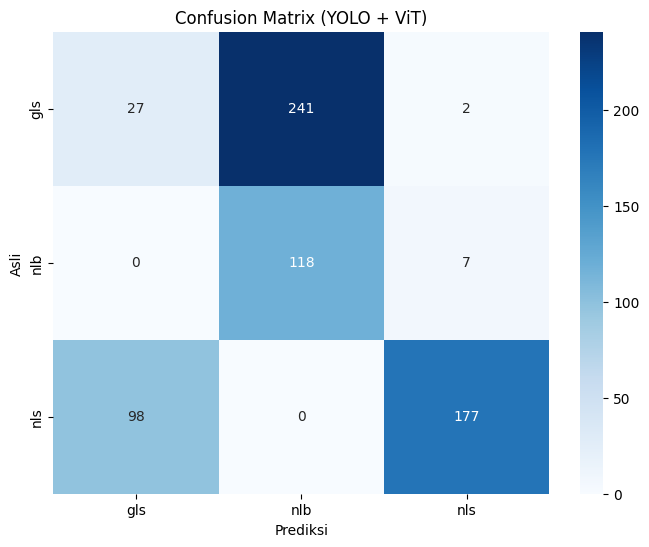

In [5]:
# 0.5 dan 0.25
import torch
import cv2
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# ================= 1. KONFIGURASI =================

# ⚠️ PENTING: Path harus berhenti di folder INDUK
INPUT_IMAGES_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images'
INPUT_LABELS_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/labels'

# Output
OUTPUT_BASE_DIR = '/content/drive/MyDrive/EAS VISIKOM/HasilYOLO_ViT/Evaluasi_Total'
OUTPUT_IMAGES_DIR = os.path.join(OUTPUT_BASE_DIR, 'Visualisasi_Citra')
os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)

# Model
YOLO_PATH = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/YOLO_best.pt'
VIT_PATH  = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/vision_transformer_corn_disease_bestViT.pth'

# Config
IOU_THRESHOLD = 0.5
CONF_THRESHOLD = 0.25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ['gls', 'nlb', 'nls']

# ================= 2. FUNGSI & LOAD MODEL =================
print(f"Device: {DEVICE}")

def xywhn2xyxy(x, y, w, h, W, H):
    x1, y1 = int((x - w/2) * W), int((y - h/2) * H)
    x2, y2 = int((x + w/2) * W), int((y + h/2) * H)
    return [max(0, x1), max(0, y1), min(W, x2), min(H, y2)]

def calculate_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    return interArea / float((boxA[2]-boxA[0])*(boxA[3]-boxA[1]) + (boxB[2]-boxB[0])*(boxB[3]-boxB[1]) - interArea + 1e-6)

# Load Models
yolo_model = YOLO(YOLO_PATH)

def initialize_vit_model(num_classes):
    model = models.vit_b_16(weights=None)
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    return model

model_vit = initialize_vit_model(len(CLASS_NAMES))
model_vit.load_state_dict(torch.load(VIT_PATH, map_location=DEVICE))
model_vit.to(DEVICE).eval()

vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ================= 3. MAIN LOOP (MULTI-FOLDER) =================
print("\n🚀 MEMULAI PIPELINE YOLO+ViT...")
y_true, y_pred, log_data = [], [], []

# --- Loop masuk ke setiap folder ---
for class_name in CLASS_NAMES:
    # Gabungkan Path Induk + Nama Kelas
    current_img_dir = os.path.join(INPUT_IMAGES_ROOT, class_name)
    current_lbl_dir = os.path.join(INPUT_LABELS_ROOT, class_name)

    print(f"\n📂 Sedang memproses folder: {current_img_dir}")

    if not os.path.isdir(current_img_dir):
        print(f"   ❌ Folder tidak ditemukan! Lewati...")
        continue

    # Cari gambar
    image_files = glob.glob(os.path.join(current_img_dir, "*.*"))
    valid_files = [f for f in image_files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(valid_files) == 0:
        print("   ⚠️ Folder kosong (tidak ada gambar).")
        continue

    print(f"   ✅ Ditemukan {len(valid_files)} gambar. Mulai deteksi...")

    for img_path in valid_files:
        filename = os.path.basename(img_path)
        label_path = os.path.join(current_lbl_dir, os.path.splitext(filename)[0] + '.txt')

        # Baca Gambar
        img_cv = cv2.imread(img_path)
        if img_cv is None: continue
        H, W, _ = img_cv.shape
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

        # Baca Label GT
        gt_boxes, gt_classes = [], []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    d = line.strip().split()
                    gt_classes.append(int(d[0]))
                    gt_boxes.append(xywhn2xyxy(float(d[1]), float(d[2]), float(d[3]), float(d[4]), W, H))

        # Prediksi YOLO
        results = yolo_model(img_path, conf=CONF_THRESHOLD, verbose=False)
        pred_boxes = [box.xyxy[0].cpu().numpy().astype(int) for r in results for box in r.boxes]

        # Matching
        matched_gt_indices = set()
        img_viz = img_cv.copy()

        # ... Loop untuk setiap kotak prediksi ...
        for p_box in pred_boxes:
            best_iou, best_gt_idx = 0, -1
            for idx, g_box in enumerate(gt_boxes):
                iou = calculate_iou(p_box, g_box)
                if iou > best_iou: best_iou, best_gt_idx = iou, idx

            # Crop & ViT
            x1, y1, x2, y2 = map(int, p_box)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)

            crop = img_pil.crop((x1, y1, x2, y2))

            if crop.size[0] > 0 and crop.size[1] > 0:
                input_tensor = vit_transforms(crop).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    preds = model_vit(input_tensor)
                    vit_pred_cls = torch.argmax(preds, 1).item()

                is_tp = (best_iou >= IOU_THRESHOLD)

                if is_tp:
                    matched_gt_indices.add(best_gt_idx)
                    gt_cls = gt_classes[best_gt_idx]
                    y_true.append(gt_cls)
                    y_pred.append(vit_pred_cls)

                    status = "CORRECT" if gt_cls == vit_pred_cls else "WRONG"
                    color = (0,255,0) if status=="CORRECT" else (0,0,255)
                    log_data.append([filename, CLASS_NAMES[gt_cls], CLASS_NAMES[vit_pred_cls], best_iou, status])

                    # Gambar Kotak Prediksi
                    cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img_viz, f"{status} ({CLASS_NAMES[vit_pred_cls]})", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Cek Missed GT
        for idx, g_box in enumerate(gt_boxes):
            if idx not in matched_gt_indices:
                gt_cls = gt_classes[idx]
                y_true.append(gt_cls)
                y_pred.append(-1) # Missed

                # Gambar Kotak Missed (Biru)
                cv2.rectangle(img_viz, (g_box[0], g_box[1]), (g_box[2], g_box[3]), (255,0,0), 2)
                cv2.putText(img_viz, f"Missed: {CLASS_NAMES[gt_cls]}", (g_box[0], g_box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

                log_data.append([filename, CLASS_NAMES[gt_cls], "Missed", 0, "Missed"])

        # --- [FIX] SIMPAN GAMBAR HASIL ---
        # Simpan di sub-folder sesuai kelas asli agar rapi
        save_class_dir = os.path.join(OUTPUT_IMAGES_DIR, class_name)
        os.makedirs(save_class_dir, exist_ok=True)

        save_path = os.path.join(save_class_dir, filename)
        cv2.imwrite(save_path, img_viz)


# ================= 4. METRIK DETEKSI (mAP) =================
print("\n" + "="*30)
print("📊 MENGHITUNG mAP (YOLO VALIDATION)...")
print("="*30)

map50 = 0
map5095 = 0

try:
    # 1. Buat file data.yaml sementara agar YOLO bisa validasi otomatis
    # Kita arahkan path 'val' ke folder parent images (YOLO recursive scan)
    ROOT_DATASET_DIR = os.path.dirname(INPUT_IMAGES_ROOT) # .../test

    # Isi file YAML
    yaml_content = f"""
path: {ROOT_DATASET_DIR}
train: images # Tidak dipakai saat val, tapi wajib ada
val: images   # Folder images (akan scan gls/nlb/nls)
names:
  0: {CLASS_NAMES[0]}
  1: {CLASS_NAMES[1]}
  2: {CLASS_NAMES[2]}
"""
    with open('temp_map_config.yaml', 'w') as f:
        f.write(yaml_content)

    print("Menjalankan YOLO validator...")
    # Jalankan validasi menggunakan model YOLO
    metrics_yolo = yolo_model.val(data='temp_map_config.yaml', split='val', verbose=False)

    map50 = metrics_yolo.box.map50
    map5095 = metrics_yolo.box.map

    print(f"✅ mAP@50    : {map50:.4f}")
    print(f"✅ mAP@50-95 : {map5095:.4f}")

except Exception as e:
    print(f"⚠️ Gagal menghitung mAP: {e}")
    print("   Pastikan folder images berisi subfolder gls/nlb/nls dan labels juga demikian.")


# ================= 5. METRIK PIPELINE & LAPORAN =================
print("\n" + "="*30)
if len(y_true) == 0:
    print("❌ ERROR: Tidak ada data yang terkumpul (y_true kosong).")
else:
    print(f"✅ Data terkumpul: {len(y_true)} sampel.")

    # Hitung Metrik Pipeline (YOLO+ViT)
    y_pred_clean = [p if p != -1 else (t + 1) % len(CLASS_NAMES) for p, t in zip(y_pred, y_true)]
    acc = accuracy_score(y_true, y_pred_clean)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred_clean, average='weighted', zero_division=0)

    print(f"   Akurasi Pipeline: {acc:.4f}")

    # Buat DataFrame Summary (Termasuk mAP)
    df_metrics = pd.DataFrame([
        ['Accuracy (Pipeline)', acc],
        ['Precision (Pipeline)', prec],
        ['Recall (Pipeline)', rec],
        ['F1-Score (Pipeline)', f1],
        ['mAP@50 (YOLO)', map50],
        ['mAP@50-95 (YOLO)', map5095]
    ], columns=['Metric', 'Value'])

    # Simpan Excel
    df_log = pd.DataFrame(log_data, columns=['File', 'GT', 'Pred', 'IoU', 'Status'])

    excel_path = os.path.join(OUTPUT_BASE_DIR, 'Laporan_Evaluasi_Lengkap.xlsx')
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        df_metrics.to_excel(writer, sheet_name='Summary', index=False)
        df_log.to_excel(writer, sheet_name='Detail_Log', index=False)

        # Classification Report
        cls_rep = classification_report(y_true, y_pred_clean, target_names=CLASS_NAMES, labels=range(len(CLASS_NAMES)), output_dict=True)
        pd.DataFrame(cls_rep).transpose().to_excel(writer, sheet_name='Class_Report')

    # Plot Confusion Matrix
    try:
        cm = confusion_matrix(y_true, y_pred_clean)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix (YOLO + ViT)')
        plt.xlabel('Prediksi')
        plt.ylabel('Asli')
        plt.savefig(os.path.join(OUTPUT_BASE_DIR, 'confusion_matrix.png'))
        print("   Semua hasil (Gambar & Excel) tersimpan.")
    except Exception as e:
        print(f"   Gagal plot grafik: {e}")

    print(f"✅ Selesai! Cek folder output: {OUTPUT_BASE_DIR}")

Device: cpu

🚀 MEMULAI PIPELINE...

📂 Sedang memproses folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/gls
   ✅ Ditemukan 21 gambar. Mulai deteksi...

📂 Sedang memproses folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nlb
   ✅ Ditemukan 26 gambar. Mulai deteksi...

📂 Sedang memproses folder: /content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images/nls
   ✅ Ditemukan 26 gambar. Mulai deteksi...

✅ Data terkumpul: 1589 sampel.
   Akurasi Pipeline: 0.9138
   Semua hasil (Gambar & Excel) tersimpan.
✅ Selesai! Cek folder output: /content/drive/MyDrive/EAS VISIKOM/HasilYOLO_ViT/Evaluasi_Total2


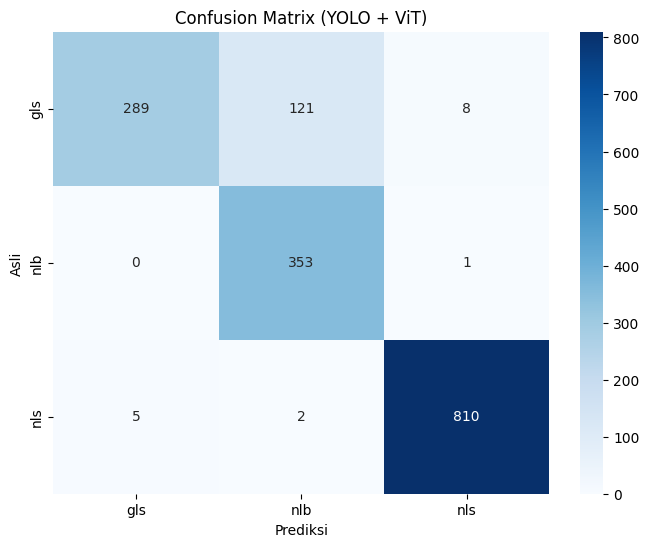

In [ ]:
# 0.25 ; 0.01
import torch
import cv2
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# ================= 1. KONFIGURASI =================

# ⚠️ PENTING: Path harus berhenti di folder INDUK
INPUT_IMAGES_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images'
INPUT_LABELS_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/labels'

# Output
OUTPUT_BASE_DIR = '/content/drive/MyDrive/EAS VISIKOM/HasilYOLO_ViT/Evaluasi_Total2'
OUTPUT_IMAGES_DIR = os.path.join(OUTPUT_BASE_DIR, 'Visualisasi_Citra')
os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)

# Model
YOLO_PATH = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/YOLO_best.pt'
VIT_PATH  = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/vision_transformer_corn_disease_bestViT.pth'

# Config
IOU_THRESHOLD = 0.25
CONF_THRESHOLD = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ['gls', 'nlb', 'nls']

# ================= 2. FUNGSI & LOAD MODEL =================
print(f"Device: {DEVICE}")

def xywhn2xyxy(x, y, w, h, W, H):
    x1, y1 = int((x - w/2) * W), int((y - h/2) * H)
    x2, y2 = int((x + w/2) * W), int((y + h/2) * H)
    return [max(0, x1), max(0, y1), min(W, x2), min(H, y2)]

def calculate_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    return interArea / float((boxA[2]-boxA[0])*(boxA[3]-boxA[1]) + (boxB[2]-boxB[0])*(boxB[3]-boxB[1]) - interArea + 1e-6)

# Load Models
yolo_model = YOLO(YOLO_PATH)

def initialize_vit_model(num_classes):
    model = models.vit_b_16(weights=None)
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    return model

model_vit = initialize_vit_model(len(CLASS_NAMES))
model_vit.load_state_dict(torch.load(VIT_PATH, map_location=DEVICE))
model_vit.to(DEVICE).eval()

vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ================= 3. MAIN LOOP (MULTI-FOLDER) =================
print("\n🚀 MEMULAI PIPELINE...")
y_true, y_pred, log_data = [], [], []

# --- Loop masuk ke setiap folder ---
for class_name in CLASS_NAMES:
    # Gabungkan Path Induk + Nama Kelas
    current_img_dir = os.path.join(INPUT_IMAGES_ROOT, class_name)
    current_lbl_dir = os.path.join(INPUT_LABELS_ROOT, class_name)

    print(f"\n📂 Sedang memproses folder: {current_img_dir}")

    if not os.path.isdir(current_img_dir):
        print(f"   ❌ Folder tidak ditemukan! Lewati...")
        continue

    # Cari gambar
    image_files = glob.glob(os.path.join(current_img_dir, "*.*"))
    valid_files = [f for f in image_files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(valid_files) == 0:
        print("   ⚠️ Folder kosong (tidak ada gambar).")
        continue

    print(f"   ✅ Ditemukan {len(valid_files)} gambar. Mulai deteksi...")

    for img_path in valid_files:
        filename = os.path.basename(img_path)
        label_path = os.path.join(current_lbl_dir, os.path.splitext(filename)[0] + '.txt')

        # Baca Gambar
        img_cv = cv2.imread(img_path)
        if img_cv is None: continue
        H, W, _ = img_cv.shape
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

        # Baca Label GT
        gt_boxes, gt_classes = [], []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    d = line.strip().split()
                    gt_classes.append(int(d[0]))
                    gt_boxes.append(xywhn2xyxy(float(d[1]), float(d[2]), float(d[3]), float(d[4]), W, H))

        # Prediksi YOLO
        results = yolo_model(img_path, conf=CONF_THRESHOLD, verbose=False)
        pred_boxes = [box.xyxy[0].cpu().numpy().astype(int) for r in results for box in r.boxes]

        # Matching
        matched_gt_indices = set()
        img_viz = img_cv.copy()

        # ... Loop untuk setiap kotak prediksi ...
        for p_box in pred_boxes:
            best_iou, best_gt_idx = 0, -1
            for idx, g_box in enumerate(gt_boxes):
                iou = calculate_iou(p_box, g_box)
                if iou > best_iou: best_iou, best_gt_idx = iou, idx

            # Crop & ViT
            x1, y1, x2, y2 = map(int, p_box)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)

            crop = img_pil.crop((x1, y1, x2, y2))

            if crop.size[0] > 0 and crop.size[1] > 0:
                input_tensor = vit_transforms(crop).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    preds = model_vit(input_tensor)
                    vit_pred_cls = torch.argmax(preds, 1).item()

                is_tp = (best_iou >= IOU_THRESHOLD)

                if is_tp:
                    matched_gt_indices.add(best_gt_idx)
                    gt_cls = gt_classes[best_gt_idx]
                    y_true.append(gt_cls)
                    y_pred.append(vit_pred_cls)

                    status = "CORRECT" if gt_cls == vit_pred_cls else "WRONG"
                    color = (0,255,0) if status=="CORRECT" else (0,0,255)
                    log_data.append([filename, CLASS_NAMES[gt_cls], CLASS_NAMES[vit_pred_cls], best_iou, status])

                    # Gambar Kotak Prediksi
                    cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img_viz, f"{status} ({CLASS_NAMES[vit_pred_cls]})", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Cek Missed GT
        for idx, g_box in enumerate(gt_boxes):
            if idx not in matched_gt_indices:
                gt_cls = gt_classes[idx]
                y_true.append(gt_cls)
                y_pred.append(-1) # Missed

                # Gambar Kotak Missed (Biru)
                cv2.rectangle(img_viz, (g_box[0], g_box[1]), (g_box[2], g_box[3]), (255,0,0), 2)
                cv2.putText(img_viz, f"Missed: {CLASS_NAMES[gt_cls]}", (g_box[0], g_box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

                log_data.append([filename, CLASS_NAMES[gt_cls], "Missed", 0, "Missed"])

        # --- [FIX] SIMPAN GAMBAR HASIL ---
        # Simpan di sub-folder sesuai kelas asli agar rapi
        save_class_dir = os.path.join(OUTPUT_IMAGES_DIR, class_name)
        os.makedirs(save_class_dir, exist_ok=True)

        save_path = os.path.join(save_class_dir, filename)
        cv2.imwrite(save_path, img_viz)

# ================= 4. METRIK (ANTI CRASH) =================
print("\n" + "="*30)
if len(y_true) == 0:
    print("❌ ERROR: Tidak ada data yang terkumpul (y_true kosong).")
else:
    print(f"✅ Data terkumpul: {len(y_true)} sampel.")

    # Hitung Metrik
    y_pred_clean = [p if p != -1 else (t + 1) % len(CLASS_NAMES) for p, t in zip(y_pred, y_true)]
    acc = accuracy_score(y_true, y_pred_clean)
    print(f"   Akurasi Pipeline: {acc:.4f}")

    # Simpan Excel
    df_log = pd.DataFrame(log_data, columns=['File', 'GT', 'Pred', 'IoU', 'Status'])
    df_log.to_excel(os.path.join(OUTPUT_BASE_DIR, 'Log_Evaluasi.xlsx'), index=False)

    # Plot Confusion Matrix
    try:
        cm = confusion_matrix(y_true, y_pred_clean)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix (YOLO + ViT)')
        plt.xlabel('Prediksi')
        plt.ylabel('Asli')
        plt.savefig(os.path.join(OUTPUT_BASE_DIR, 'confusion_matrix.png'))
        print("   Semua hasil (Gambar & Excel) tersimpan.")
    except Exception as e:
        print(f"   Gagal plot grafik: {e}")

    print(f"✅ Selesai! Cek folder output: {OUTPUT_BASE_DIR}")

# Coba Langsung

YOLO + CNN

⏳ Loading Models...

🎲 Mengambil Gambar Acak: nlb_87.jpg (Asli: nlb)
   - Ground Truth Objects : 6
   - YOLO Detected Objects: 7


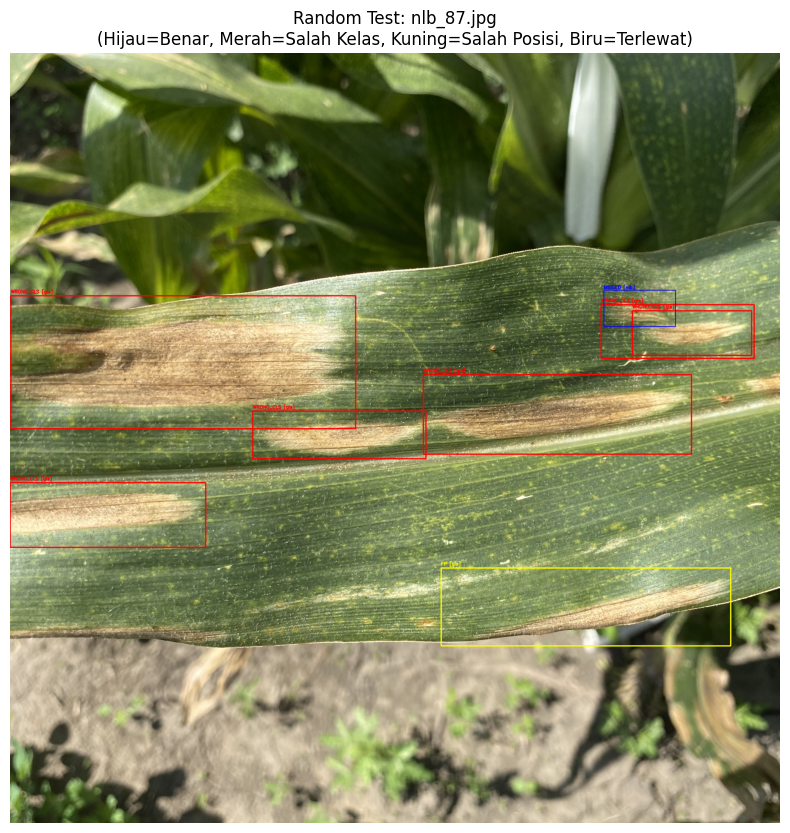

In [ ]:
import torch
import cv2
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from ultralytics import YOLO
from PIL import Image

# ================= 1. KONFIGURASI =================
INPUT_IMAGES_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images'
INPUT_LABELS_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/labels'

# Model Paths
YOLO_PATH = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/YOLO_best.pt'
CNN_PATH  = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/model_terbaikCNN.keras'

# Parameters
CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.5
CNN_INPUT_SIZE = (128, 128) # Sesuaikan input shape CNN Anda
CLASS_NAMES = ['gls', 'nlb', 'nls']

# ================= 2. FUNGSI BANTUAN =================
def xywhn2xyxy(x, y, w, h, W, H):
    x1, y1 = int((x - w/2) * W), int((y - h/2) * H)
    x2, y2 = int((x + w/2) * W), int((y + h/2) * H)
    return [max(0, x1), max(0, y1), min(W, x2), min(H, y2)]

def calculate_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    return interArea / float((boxA[2]-boxA[0])*(boxA[3]-boxA[1]) + (boxB[2]-boxB[0])*(boxB[3]-boxB[1]) - interArea + 1e-6)

def preprocess_for_cnn(pil_image, target_size):
    img_resized = pil_image.resize(target_size)
    img_array = np.array(img_resized).astype(np.float32)
    img_array /= 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# ================= 3. LOAD MODEL & DATA =================
print("⏳ Loading Models...")
yolo_model = YOLO(YOLO_PATH)
model_cnn = tf.keras.models.load_model(CNN_PATH)

# Kumpulkan semua gambar dari semua subfolder
all_images = []
for cls in CLASS_NAMES:
    folder_path = os.path.join(INPUT_IMAGES_ROOT, cls)
    if os.path.exists(folder_path):
        all_images.extend(glob.glob(os.path.join(folder_path, "*.*")))

if not all_images:
    print("❌ Tidak ada gambar ditemukan!")
    exit()

# ================= 4. PROSES 1 GAMBAR ACAK =================

# Pilih Random
target_img_path = random.choice(all_images)
filename = os.path.basename(target_img_path)
parent_folder = os.path.basename(os.path.dirname(target_img_path)) # Nama folder kelasnya

print(f"\n🎲 Mengambil Gambar Acak: {filename} (Asli: {parent_folder})")

# Cari Labelnya
label_path = os.path.join(INPUT_LABELS_ROOT, parent_folder, os.path.splitext(filename)[0] + '.txt')

# Baca Gambar
img_cv = cv2.imread(target_img_path)
H, W, _ = img_cv.shape
img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
img_viz = img_cv.copy()

# Baca GT
gt_boxes, gt_classes = [], []
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f.readlines():
            d = line.strip().split()
            if len(d) >= 5:
                gt_classes.append(int(d[0]))
                gt_boxes.append(xywhn2xyxy(float(d[1]), float(d[2]), float(d[3]), float(d[4]), W, H))

# Prediksi YOLO
results = yolo_model(target_img_path, conf=CONF_THRESHOLD, verbose=False)
pred_boxes = [box.xyxy[0].cpu().numpy().astype(int) for r in results for box in r.boxes]

# Matching & CNN
matched_gt_indices = set()

print(f"   - Ground Truth Objects : {len(gt_boxes)}")
print(f"   - YOLO Detected Objects: {len(pred_boxes)}")

for p_box in pred_boxes:
    best_iou, best_gt_idx = 0, -1
    for idx_g, g_box in enumerate(gt_boxes):
        iou = calculate_iou(p_box, g_box)
        if iou > best_iou: best_iou, best_gt_idx = iou, idx_g

    # Crop & CNN
    x1, y1, x2, y2 = map(int, p_box)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W, x2), min(H, y2)

    crop = img_pil.crop((x1, y1, x2, y2))

    if crop.size[0] > 0 and crop.size[1] > 0:
        # Predict Keras
        input_data = preprocess_for_cnn(crop, CNN_INPUT_SIZE)
        tf_tensor = tf.convert_to_tensor(input_data)
        outputs = model_cnn.predict(tf_tensor, verbose=0)
        cnn_pred_cls = np.argmax(outputs, axis=1)[0]

        is_tp = (best_iou >= IOU_THRESHOLD)

        if is_tp:
            matched_gt_indices.add(best_gt_idx)
            gt_cls = gt_classes[best_gt_idx]
            status = "CORRECT" if gt_cls == cnn_pred_cls else "WRONG_CLS"
            color = (0, 255, 0) if status == "CORRECT" else (0, 0, 255) # Hijau/Merah

            label_text = f"{status} [{CLASS_NAMES[cnn_pred_cls]}]"
        else:
            color = (0, 255, 255) # Kuning (FP)
            label_text = f"FP [{CLASS_NAMES[cnn_pred_cls]}]"

        # Gambar Kotak
        cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, 3)
        cv2.putText(img_viz, label_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Gambar Missed GT
for idx_g, g_box in enumerate(gt_boxes):
    if idx_g not in matched_gt_indices:
        gt_cls = gt_classes[idx_g]
        cv2.rectangle(img_viz, (g_box[0], g_box[1]), (g_box[2], g_box[3]), (255, 0, 0), 2) # Biru
        cv2.putText(img_viz, f"MISSED [{CLASS_NAMES[gt_cls]}]", (g_box[0], g_box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

# ================= 5. TAMPILKAN HASIL =================
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_viz, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Random Test: {filename}\n(Hijau=Benar, Merah=Salah Kelas, Kuning=Salah Posisi, Biru=Terlewat)")
plt.show()

YOLO + ViT

⏳ Loading Models on cpu...

🎲 Gambar Terpilih: nls_365.jpg
🏷️ Label Asli (dari folder): nls
🔍 YOLO Mendeteksi: 4 objek


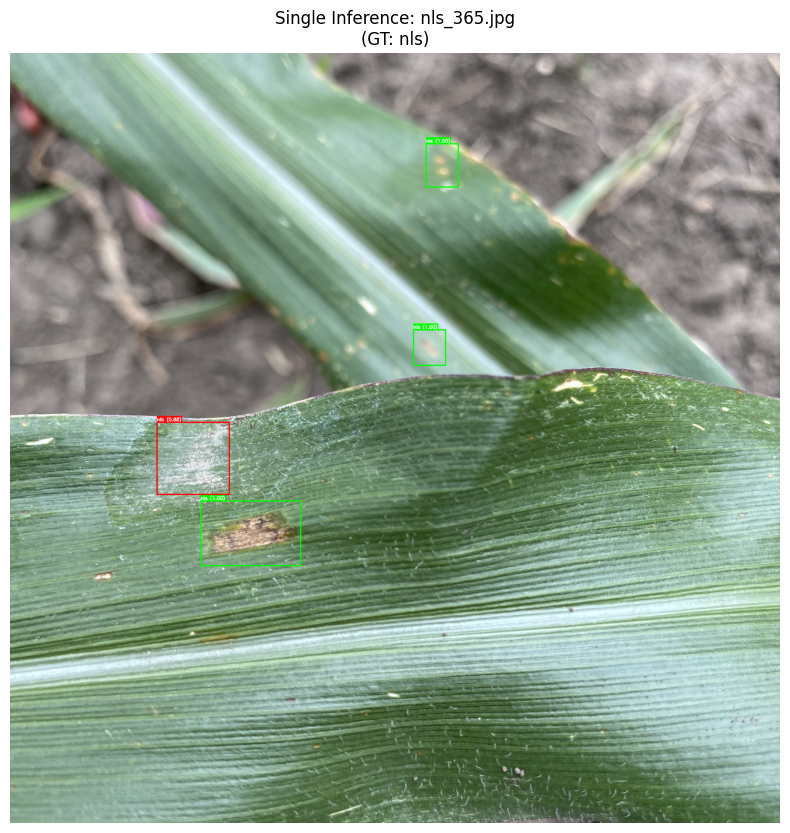

In [ ]:
import torch
import cv2
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image

# ================= 1. KONFIGURASI =================
INPUT_IMAGES_ROOT = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/Split/test/images'

# Path Model
YOLO_PATH = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/YOLO_best.pt'
VIT_PATH  = '/content/drive/MyDrive/EAS VISIKOM/Dataset_EAS_Annotated/ALL MODEL/vision_transformer_corn_disease_bestViT.pth'

# Config
CONF_THRESHOLD = 0.25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ['gls', 'nlb', 'nls']

# ================= 2. LOAD MODEL =================
print(f"⏳ Loading Models on {DEVICE}...")

# Load YOLO
yolo_model = YOLO(YOLO_PATH)

# Load ViT
def initialize_vit_model(num_classes):
    model = models.vit_b_16(weights=None)
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    return model

model_vit = initialize_vit_model(len(CLASS_NAMES))
model_vit.load_state_dict(torch.load(VIT_PATH, map_location=DEVICE))
model_vit.to(DEVICE).eval()

# Transform ViT
vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ================= 3. AMBIL GAMBAR ACAK =================
all_images = []
for cls in CLASS_NAMES:
    folder_path = os.path.join(INPUT_IMAGES_ROOT, cls)
    if os.path.exists(folder_path):
        all_images.extend(glob.glob(os.path.join(folder_path, "*.*")))

if not all_images:
    print("❌ Tidak ada gambar ditemukan di folder input!")
    exit()

# Pilih 1 Random
target_img_path = random.choice(all_images)
filename = os.path.basename(target_img_path)
parent_folder = os.path.basename(os.path.dirname(target_img_path)) # Nama folder = Label Asli

print(f"\n🎲 Gambar Terpilih: {filename}")
print(f"🏷️ Label Asli (dari folder): {parent_folder}")

# ================= 4. PROSES INFERENCE =================

# Baca Gambar
img_cv = cv2.imread(target_img_path)
H, W, _ = img_cv.shape
img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
img_viz = img_cv.copy()

# 1. Prediksi YOLO
results = yolo_model(target_img_path, conf=CONF_THRESHOLD, verbose=False)
pred_boxes = [box.xyxy[0].cpu().numpy().astype(int) for r in results for box in r.boxes]

print(f"🔍 YOLO Mendeteksi: {len(pred_boxes)} objek")

if len(pred_boxes) == 0:
    print("⚠️ YOLO tidak mendeteksi apapun di gambar ini.")
    cv2.putText(img_viz, "YOLO: No Detection", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# 2. Loop Deteksi -> Crop -> ViT
for i, box in enumerate(pred_boxes):
    x1, y1, x2, y2 = map(int, box)

    # Validasi koordinat
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W, x2), min(H, y2)

    # Crop
    crop = img_pil.crop((x1, y1, x2, y2))

    if crop.size[0] > 0 and crop.size[1] > 0:
        # ViT Inference
        input_tensor = vit_transforms(crop).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            preds = model_vit(input_tensor)
            probs = torch.nn.functional.softmax(preds, dim=1)
            conf_score, pred_idx = torch.max(probs, 1)

        vit_pred_cls = CLASS_NAMES[pred_idx.item()]
        confidence = conf_score.item()

        # Cek Benar/Salah (Berdasarkan nama folder)
        is_correct = (vit_pred_cls == parent_folder)

        # Visualisasi
        color = (0, 255, 0) if is_correct else (0, 0, 255) # Hijau=Benar, Merah=Salah
        label_text = f"{vit_pred_cls} ({confidence:.2f})"

        # Gambar Kotak
        cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, 3)

        # Background teks agar terbaca
        (w_text, h_text), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img_viz, (x1, y1 - 25), (x1 + w_text, y1), color, -1)
        cv2.putText(img_viz, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

# ================= 5. TAMPILKAN HASIL =================
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_viz, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Single Inference: {filename}\n(GT: {parent_folder})")
plt.show()